# Compare different clustering algorithms

Evaluate different clustering algorithms by analyzing the homogeneity and completeness of the clusters.

In [1]:
import time, sys

import math
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.utils import murmurhash3_32
from collections import Counter

sys.path.append('../')
from ms_io import ms_io
from cluster import spectrum
import nb_utils
import dr_utils

### Import the spectra and convert them to low-dimension vectors

In [2]:
mz_split = 600
charge = 2
_min_mz, _max_mz = 101., 1500.
fragment_mz_tolerance = 0.05

path = f'/media/maesk/WD/falcon/PXD000561/spectra'

cnt, limit = 0, 10000 # Use a subset of 10000 spectra
sps = []
for sp in nb_utils.read_spectra_from_bucket(charge, path, mz_split):
    if limit is not None and cnt == limit:
        break

    sp = nb_utils.process_spectrum(sp)
    if sp is not None:
        sps.append(sp)
        cnt = cnt + 1

# Store the spectra in a dataframe
df_sps = pd.DataFrame({'identifier': [sp.identifier for sp in sps],
                       'sp': sps})

# Import the labels
file_labels = '/media/maesk/WD/MS/PXD000561/kim2014_ids.csv'
labels = pd.read_csv(file_labels)
labels = labels[labels['identifier'].isin(df_sps['identifier'])]
labels['sequence'] = labels['sequence'].str.replace('L', 'I')
assert len(labels) == len(df_sps)

# Merge the dataframe containing the spectra and the labels
df_sps_lab = df_sps.merge(labels, on='identifier')

print('Number of spectra: %d' % (len(df_sps_lab),))

#proplabeled = len([id for id in df_sps_lab['sequence'].tolist() if not pd.isna(id)])/len(labels)
proplabeled = sum(~pd.isna(df_sps_lab['sequence']))/len(df_sps_lab)
print('Proportion of labeled spectra', proplabeled)
assert proplabeled > 0.3 # Make sure we have enough labels to make reliable conclusions

df_sps_lab.sort_values(by='precursor_mz', inplace=True)

vec_len, min_mz, max_mz = spectrum.get_dim(_min_mz, _max_mz, 0.05)
hash_lookup = np.asarray([murmurhash3_32(i, 0, True) % 800
                              for i in range(vec_len)], np.uint32)
vec_ld = spectrum.to_vector_parallel(df_sps_lab['sp'].tolist(), dim=800, min_mz=min_mz, # Low dimensional vectors
                                     max_mz=max_mz, bin_size=0.05,
                                     hash_lookup=hash_lookup, norm=True)


Number of spectra: 10000
Proportion of labeled spectra 0.407


In [3]:
mask_labeled = ~pd.isna(df_sps_lab['sequence'])
vec_hd = dr_utils.sp_to_vecHD(df_sps_lab['sp'].tolist(),
                               min_mz, max_mz, fragment_mz_tolerance) # High dimensional vectors

print(sum(mask_labeled))
print(len(df_sps_lab))
print('Range precursor mz', min(df_sps_lab['precursor_mz']), max(df_sps_lab['precursor_mz']))

4070
10000
Range precursor mz 600.0245361328131 600.338928222656


In [31]:
print(Counter(labels.dropna()['sequence']).most_common())

sel_sequences = ['DIIIDPAWEK', # Size 373
                 '[UNIMOD:5]EIIEIAGNAAR', # Size 136,
                 'TPVPSDIDISR', # Size 126
                 'DSYVGDEAQSK', # Size 121
                 'RAEQIIQDAR', # Size 118
                 'AEFGPPGPGAGSR', # Size 103
                 'AYPIADAHITK', # Size 88
                 'VKSPEIQAEAK', # Size 71
                 'IIGYFVEAC[UNIMOD:4]K', # Size 64
                 'IFC[UNIMOD:4]SEYRPK', # Size 58
                 'DAGTIAGINVIR', # Size 33
                 'SAEAYENFIR' # Size 20
                ]
        
mask_sel_lab = df_sps_lab['sequence'].isin(sel_sequences)
print('Size of the labeled selection:', sum(mask_sel_lab))

# Mix the labeled clusters > 20 with some unlabeled spectra
mask_unlabeled = pd.isna(df_sps_lab['sequence'])
n_unlabeled = int(1*sum(mask_sel_lab))
df_sel = df_sps_lab[mask_sel_lab].append(df_sps_lab[mask_unlabeled].head(n_unlabeled))
print('Total size of the selection:', len(df_sel))

[('DIIIDPAWEK', 373), ('[UNIMOD:5]EIIEIAGNAAR', 136), ('TPVPSDIDISR', 126), ('DSYVGDEAQSK', 121), ('RAEQIIQDAR', 118), ('AEFGPPGPGAGSR', 103), ('TSFIDDAFRK', 94), ('QVIIAQAEAEK', 88), ('AYPIADAHITK', 88), ('[UNIMOD:5]IVIIEGDIER', 79), ('VKSPEIQAEAK', 71), ('IIGYFVEAC[UNIMOD:4]K', 64), ('DSYVGDEAQ[UNIMOD:7]SK', 63), ('AVSEEQQPAIK', 59), ('IPSGSDHVM[UNIMOD:35]IK', 59), ('IFC[UNIMOD:4]SEYRPK', 58), ('AASQPTSIAPEK', 56), ('SFIYEIVSNK', 56), ('IVQIHVDTM[UNIMOD:35]K', 49), ('GSYMEVEDNR', 42), ('TISGGIQVN[UNIMOD:7]GPR', 40), ('DDVVAPDIDIK', 36), ('QVM[UNIMOD:35]YQQSSGR', 35), ('TMQDSVEDFK', 35), ('DAGTIAGINVIR', 33), ('VDPIETEIGVK', 33), ('VEIEAAIQQAK', 32), ('DGGFC[UNIMOD:4]EVC[UNIMOD:4]KK', 30), ('MGFPEAASSFR', 30), ('VQITPGQTEVK', 29), ('SFSEFGKIER', 29), ('EQHPDMSVTR', 28), ('AVFPSIVGRPR', 27), ('VYNYVDWIK', 26), ('GQPDTVQDAIR', 25), ('[UNIMOD:5]VKGDVDVSIPK', 25), ('TSEM[UNIMOD:35]EASSSVR', 25), ('QMIPINTNIR', 24), ('[UNIMOD:1]VKGDVDVSIPK', 24), ('VGNESPVQEIK', 23), ('KTQVIQPEEK', 23), ('

Make a visualization of the spectra, with t-SNE

In [32]:
# Apply PCA to reduce the data to 50 components then TSNE
mask_sel = df_sps_lab['identifier'].isin(df_sel['identifier'])
print(sum(mask_sel))
vec_PCA_sel = sklearn.decomposition.PCA(n_components=50).fit_transform(vec_hd[mask_sel])
vec_PCA_all = sklearn.decomposition.PCA(n_components=50).fit_transform(vec_hd)

# Apply tSNE to plot
perplexity=30
n_iter = 1000
learning_rate = 200
vec_2d_all = sklearn.manifold.TSNE(n_components=2, perplexity=perplexity, \
                               n_iter=n_iter, random_state=42, learning_rate=learning_rate, \
                                  early_exaggeration=12).fit_transform(vec_PCA_all)
vec_2d_sel = sklearn.manifold.TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, \
                               n_iter=n_iter, random_state=42, early_exaggeration=12)\
                                .fit_transform(vec_PCA_sel)


2624


KeyboardInterrupt: 

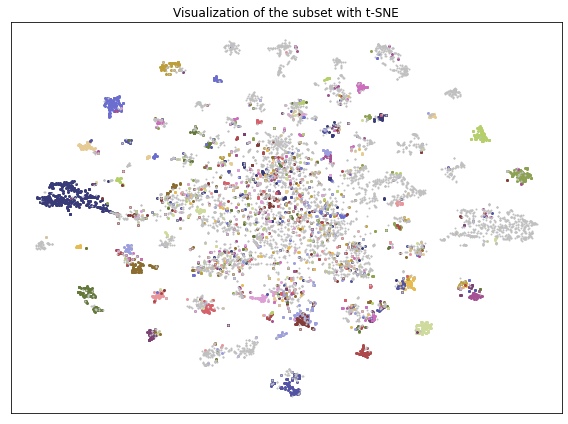

In [81]:
def plotClusters(vec_2d, labels, ax, param=None):
    mask_noise = (labels==-1) | (pd.isna(labels))
    unique_labels = [l for l, c in Counter(labels[~mask_noise]).most_common()]
    #colors = plt.cm.gist_rainbow(np.linspace(0, 1, len(unique_labels)))
    colors = plt.cm.tab20b(np.linspace(0, 1, 20))
    
    for i in range(len(unique_labels)):
        mask = labels==unique_labels[i]
        ax.scatter(vec_2d[mask,0], vec_2d[mask,1], s=4, color=colors[i%20])
        
    ax.scatter(vec_2d[mask_noise,0], vec_2d[mask_noise,1], s=1, color='silver')
    ax.set(xticks=[], yticks=[])
    
    if param is not None:
        #ax.text(-50, -40, '%% cl = %.2f'%(param[0]), fontsize='large', ha='left')
        #ax.text(-94, -85, 'k   = %d'%(param[1]), fontsize='large', ha='left')
        ax.text(-94, -87, 'k>1 = %d'%(param[2]), fontsize='large', ha='left')
        ax.text(-94, -95, 'h   = %.2f'%(param[3],), fontsize='large', ha='left')
        ax.text(-94, -103, 'c   = %.2f'%(param[4]), fontsize='large', ha='left')

fig, ax = plt.subplots(figsize=(8,6))
plotClusters(vec_2d_all, df_sps_lab['sequence'].to_numpy(), ax, None)
#plotClusters(vec_2d_sel, df_sps_lab.loc[mask_sel,'sequence'].to_numpy(), ax, None)
ax.set(title='Visualization of the subset with t-SNE')
plt.tight_layout()
plt.savefig(f'visualization/10000first/sequences_perplexity{perplexity}_niter{n_iter}_learningrate={learning_rate}.png', dpi=300)
plt.show()

In [75]:
# Tag the singleton clusters as noise
def labelsToNoise(labels):
    for i in range(0, max(labels)+1):
        mask = labels==i
        if sum(mask) == 1:
            labels[mask] = -1
    return labels


def getMetrics(labels, sequences):
    labels = labelsToNoise(labels)
    mask_noise = labels==-1
    labels_reassign = np.copy(labels)
    labels_reassign[mask_noise] = np.arange(max(labels)+1, max(labels)+1+sum(mask_noise))
    
    mask_labels = (~pd.isna(sequences))
    h = sklearn.metrics.homogeneity_score(sequences[mask_labels], labels_reassign[mask_labels])
    c = sklearn.metrics.completeness_score(sequences[mask_labels], labels_reassign[mask_labels])
    prop_cl = sum(labels!=-1)/len(labels)
    
    # Consider noise as clusters
    unique_labels = set(labels_reassign.tolist())
    k = len(unique_labels) # K nonnoise
    
    # Don't consider noise as clusters
    unique_labels = set(labels.tolist())
    if -1 in unique_labels:
        unique_labels.remove(-1)
    k_nonnoise = len(unique_labels) # K nonnoise

    return h, c, prop_cl, k, k_nonnoise

In [ ]:
parameters = [[0.05, 100, 0.2],
              [0.1, 30, 0.6],
              [0.14, 10, 1.0]]
              
dim = (len(parameters), len(parameters[0]))
fig, axs = plt.subplots(dim[0], dim[1], figsize=(5*dim[1], 5*dim[0]))

for i in tqdm(range(len(parameters))):
    row = parameters[i]
    for j in range(3):
        if j==0: # Apply DBSCAN
            alg = 'DBSCAN'
            clust_labels = sklearn.cluster.DBSCAN(eps=row[j], min_samples=2, metric='cosine').fit(vec_ld).labels_
            axs[i,j].set(title=f'{alg}, eps={row[j]}')
        elif j==1:
            alg = 'k-means'
            clust_labels = sklearn.cluster.KMeans(n_clusters=row[j], init='random', n_init=1, random_state=2).fit(vec_ld).labels_
            axs[i,j].set(title=f'{alg}, k={row[j]}')
        elif j==2:
            alg = 'Aggl. hierarchical'
            clust_labels = sklearn.cluster \
                            .AgglomerativeClustering(n_clusters=None, distance_threshold=row[j], 
                                                     linkage='complete', affinity='cosine') \
                            .fit(vec_ld).labels_
            axs[i,j].set(title=f'{alg}, k={row[j]}')
        
        h, c, prop_cl, k_nonnoise = getMetrics(clust_labels, df_sps_lab['sequence'])
        plotClusters(vec_2d_all, clust_labels, axs[i,j], (prop_cl, k_nonnoise, h, c))
        


plt.tight_layout()
plt.savefig('visualization/comparison_plot.png', dpi=300)
plt.show()


In [95]:
def getKMeansMetrics(n):
    k_all, metrics = np.linspace(1, 3000, n).astype(int), []
    
    for k in tqdm(k_all, desc='k-means'):
        clust_labels = sklearn.cluster.KMeans(n_clusters=k, init='random', n_init=1).fit(vec_ld).labels_
        metrics.append(getMetrics(clust_labels, df_sps_lab['sequence']))
    
    return k_all, metrics


def getDBSCANMetrics(n):
    eps_all, metrics = np.linspace(0.3, 0.01, n), []
    
    for eps in tqdm(eps_all, desc='DBSCAN'):
        clust_labels = sklearn.cluster.DBSCAN(eps=eps, min_samples=2, metric='cosine').fit(vec_ld).labels_
        metrics.append(getMetrics(clust_labels, df_sps_lab['sequence']))
        
    return eps_all, metrics


def getAgglMetrics(n):
    thr_all, metrics = np.linspace(0.9, 0.05, n), []
    
    for thr in tqdm(thr_all, desc='Aggl. hierarchical'):
        clust_labels = sklearn.cluster \
                            .AgglomerativeClustering(n_clusters=None, distance_threshold=thr, \
                                                     linkage='average', affinity='cosine') \
                            .fit(vec_ld).labels_
        metrics.append(getMetrics(clust_labels, df_sps_lab['sequence']))

    return thr_all, metrics


In [98]:
n = 10
metrics_all_algos = [('DBSCAN', getDBSCANMetrics(n), 'eps'),
                     ('k-means', getKMeansMetrics(n), 'k'),
                     ('Aggl. hierarchical', getAgglMetrics(n), 'd_thr')]

DBSCAN:   0%|          | 0/10 [00:00<?, ?it/s]

k-means:   0%|          | 0/10 [00:00<?, ?it/s]

Aggl. hierarchical:   0%|          | 0/10 [00:00<?, ?it/s]

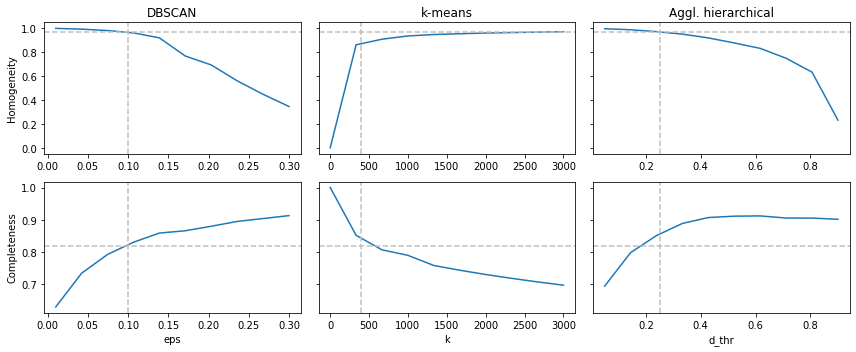

In [102]:
param_sel = [0.1, 2500, 0.25]

fig, axs = plt.subplots(2, 3, figsize=(12,5), sharey='row')
for i in range(len(metrics_all_algos)):   
    algo = metrics_all_algos[i][0]
    param, metrics = metrics_all_algos[i][1]
    param_name = metrics_all_algos[i][2]
    
    # Homogeneity
    h = [m[0] for m in metrics]
    axs[0,i].plot(param, h, label=algo)
    axs[0,i].set(title=algo)
    axs[0,i].axhline(y = 0.97, color = 'silver', linestyle = '--')
    axs[0,i].axvline(x=param_sel[i], color = 'silver', linestyle = '--')
    
    # Completeness
    c = [m[1] for m in metrics]
    axs[1,i].plot(param, c)
    axs[1,i].axhline(y = 0.82, color = 'silver', linestyle = '--')
    axs[1,i].axvline(x=param_sel[i], color = 'silver', linestyle = '--')
    
    # Prop clustered
    #prop_cl = [m[2] for m in metrics]
    #axs[2,i].plot(param, prop_cl)
    
    # k non noise
    #k = [m[3] for m in metrics]
    #axs[3,i].plot(param, k)
    
    axs[1,i].set(xlabel=param_name)
    
axs[0,0].set(ylabel='Homogeneity')
axs[1,0].set(ylabel='Completeness')
#axs[2,0].set(ylabel='Prop. sp. clustered')
#axs[3,0].set(ylabel='# clusters')
plt.tight_layout()
plt.savefig('visualization/comparison_all_test.png')
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

1.0027101039886475
30.543976068496704


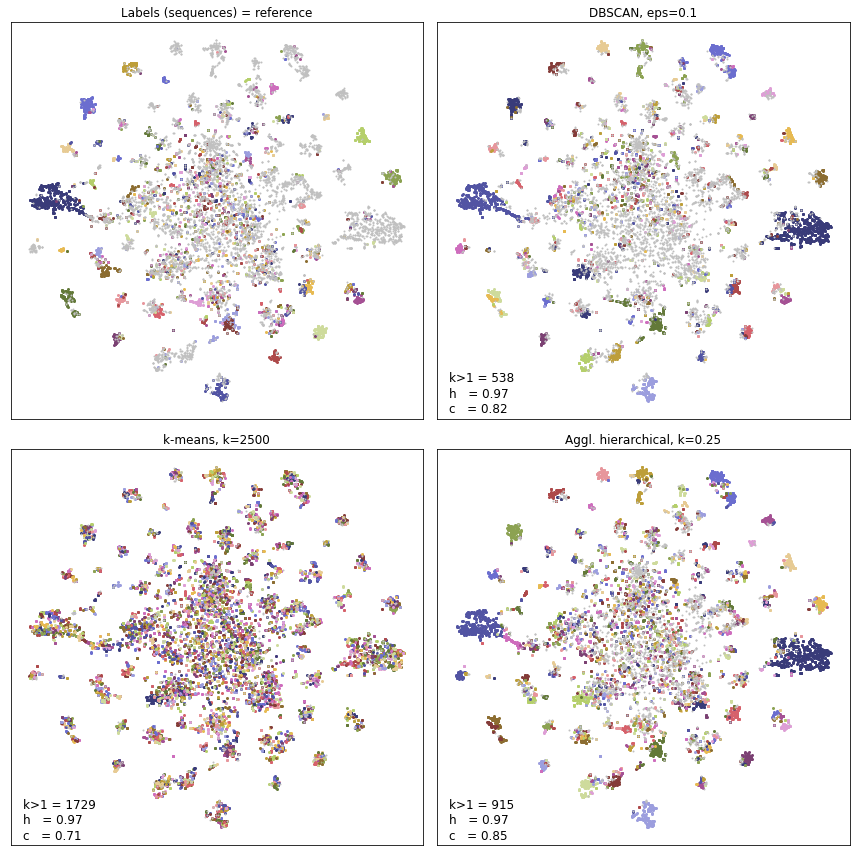

In [107]:
# Compare the 3 algos for their "best" parameters
fig, axs = plt.subplots(2, 2, figsize=(12,12))
plotClusters(vec_2d_all, df_sps_lab['sequence'].to_numpy(), axs[0,0], None)
axs[0,0].set(title='Labels (sequences) = reference')
plt.tight_layout()

save_cl = {}

parameters = [0.1, 2500, 0.25]
for i in tqdm(range(len(parameters))):
    p = parameters[i]
    
    if i==0: # Apply DBSCAN
        alg = 'DBSCAN'
        #startTime = time.time()
        clust_labels = sklearn.cluster.DBSCAN(eps=p, min_samples=2, metric='cosine').fit(vec_ld).labels_
        #print(time.time()-startTime)
        h, c, prop_cl, k, k_nonnoise = getMetrics(clust_labels, df_sps_lab['sequence'])
        plotClusters(vec_2d_all, clust_labels, axs[0,1], (prop_cl, k, k_nonnoise, h, c))
        axs[0,1].set(title=f'{alg}, eps={p}')
        
        save_cl['DBSCAN'] = clust_labels
    elif i==1:
        alg = 'k-means'
        clust_labels = sklearn.cluster.KMeans(n_clusters=p, init='random', n_init=1, random_state=2).fit(vec_ld).labels_
        h, c, prop_cl, k, k_nonnoise = getMetrics(clust_labels, df_sps_lab['sequence'])
        plotClusters(vec_2d_all, clust_labels, axs[1,0], (prop_cl, k, k_nonnoise, h, c))
        axs[1,0].set(title=f'{alg}, k={p}')
    elif i==2:
        alg = 'Aggl. hierarchical'
        #startTime=time.time()
        clust_labels = sklearn.cluster \
                        .AgglomerativeClustering(n_clusters=None, distance_threshold=p, 
                                                 linkage='average', affinity='cosine') \
                        .fit(vec_ld).labels_
        #print(time.time()-startTime)
        h, c, prop_cl, k, k_nonnoise = getMetrics(clust_labels, df_sps_lab['sequence'])
        plotClusters(vec_2d_all, clust_labels, axs[1,1], (prop_cl, k, k_nonnoise, h, c))
        axs[1,1].set(title=f'{alg}, k={p}')
        
        save_cl['aggl'] = clust_labels

    
plt.tight_layout()
plt.savefig(f'visualization/comp_bestparameters.png', dpi=300)  
plt.show()

In [108]:
# Compute the time measurements
times = [('DBSCAN', [1.00, 1.02, 0.89]),
         ('Aggl.', [31.08, 30.75, 30.54])]
for alg, t in times:
    m = np.mean(t)
    sd = np.std(t)
    print(alg, m, sd)

DBSCAN 0.9700000000000001 0.057154760664940824
Aggl. 30.790000000000003 0.22226110770892826


In [111]:
# Plot the cluster sizes distribution
def labelsToSizes(l):
    l = labelsToNoise(l) # Tag the singleton clusters as noise
    s = []
    for i in range(0, max(l)+1): # Not very efficient but it'll do the job
        mask = l==i
        if sum(mask) > 0:
            s.append(sum(mask))
            
    return s

sizes = {'DBSCAN': labelsToSizes(save_cl['DBSCAN']), 
         'aggl': labelsToSizes(save_cl['aggl'])}

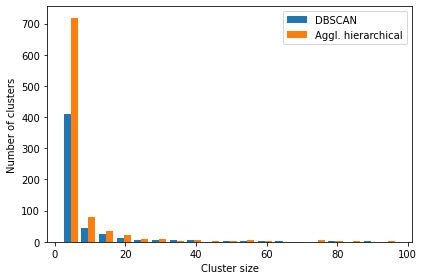

In [127]:
fig, ax = plt.subplots(figsize=(6,4))
ax.hist([sizes['DBSCAN'], sizes['aggl']],
        label=['DBSCAN','Aggl. hierarchical'],
        bins=np.arange(2,100, 5))
ax.set(xlabel='Cluster size', ylabel='Number of clusters')
plt.legend()
plt.tight_layout()
plt.savefig('visualization/sizes.png', dpi=300)
plt.show()

### Check if close pairs tend to respect the precursor mass constraint

In [ ]:
'''distances = []
precursormz = []

dist = sklearn.metrics.euclidean_distances(vec_ld)

for i in tqdm(range(len(sps))):
    for j in range(len(sps)):
        distances.append(dist[i,j])
        precursormz.append(abs(sps[i].precursor_mz - sps[j].precursor_mz))

distances = np.asarray(distances)
precursormz = np.asarray(precursormz)'''

In [ ]:
'''mask_close = distances<0.31
print('mz interval:', sps[0].precursor_mz, sps[-1].precursor_mz)
tol = sps[0].precursor_mz*20/10**6
print(sum(precursormz[mask_close] < tol) / sum(mask_close))
print(np.mean(precursormz[mask_close]))
print(np.mean(precursormz[~mask_close]))'''

### Compare several dimensionality reduction methods

In [4]:
# Compute the distances between vectors for the different methods
def getDistances(sps, vec_hd, n_components):
    nsp = len(vec_hd)
    
    hd_distances = sklearn.metrics.pairwise.cosine_distances(vec_hd).reshape(nsp**2,1)
    
    
    vec_len, min_mz, max_mz = spectrum.get_dim(_min_mz, _max_mz, 0.05)
    hash_lookup = np.asarray([murmurhash3_32(i, 0, True) % n_components
                              for i in range(vec_len)], np.uint32)
    startTime = time.time()
    vec_falc = spectrum.to_vector_parallel(sps, dim=n_components, min_mz=min_mz, # Low dimensional vectors
                                     max_mz=max_mz, bin_size=0.05,
                                     hash_lookup=hash_lookup, norm=True)
    #vec_falc = dr_utils.reduction_falcon(vec_hd, n_components)
    print('Falcon:', time.time()-startTime)
    dist_falc = sklearn.metrics.pairwise.cosine_distances(vec_falc).reshape(nsp**2,1)
    
    startTime = time.time()
    vec_PCA = sklearn.decomposition.PCA(n_components=n_components).fit_transform(vec_hd)
    print('PCA:', time.time()-startTime)
    dist_PCA = sklearn.metrics.pairwise.cosine_distances(vec_PCA).reshape(nsp**2,1)
    
    startTime = time.time()
    vec_Gaussian = sklearn.random_projection.GaussianRandomProjection(n_components=n_components, random_state=2).fit_transform(vec_hd)
    print('Gaussian:', time.time()-startTime)
    dist_Gaussian = sklearn.metrics.pairwise.cosine_distances(vec_Gaussian).reshape(nsp**2,1)
    
    return hd_distances, dist_falc, dist_PCA, dist_Gaussian

distances = getDistances(df_sps_lab['sp'].tolist()[:5000], vec_hd[0:5000,:], 800)

Falcon: 0.49216508865356445
PCA: 48.08227300643921
Gaussian: 4.696098327636719


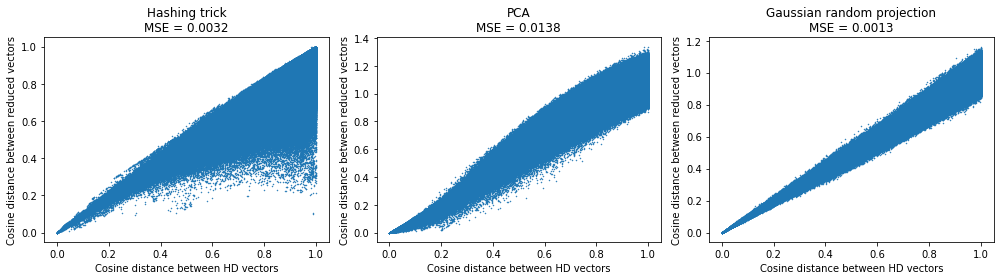

In [5]:
names = ('Hashing trick', 'PCA', 'Gaussian random projection')
#test = sklearn.metrics.pairwise.cosine_distances(vec_ld[:2000]).reshape(2000**2,1)

fig, axs = plt.subplots(1,3,figsize=(14,4))
for i in range(3):
    # Compute the MSE
    mse = sklearn.metrics.mean_squared_error(distances[0], distances[i+1])
    
    title='%s\nMSE = %.4f'%(names[i],mse,)
    axs[i].scatter(distances[0], distances[i+1], s=0.1)
    axs[i].set(xlabel='Cosine distance between HD vectors',
              ylabel='Cosine distance between reduced vectors',
              title=title)
plt.tight_layout()
plt.savefig('dimensionReduction/ncomponents_800.png', dpi=300)
plt.show()

In [9]:
# Reduce the dimension and see how MSE evolves
dimensions = [800, 400, 200, 100, 50]
for n_components in dimensions:
    print('# components', n_components)
    distances = getDistances(df_sps_lab['sp'].tolist()[:5000], vec_hd[0:5000,:], n_components)
    print('Hashing trick:', sklearn.metrics.mean_squared_error(distances[0], distances[1]))
    print('PCA:', sklearn.metrics.mean_squared_error(distances[0], distances[2]))
    print('Gaussian:', sklearn.metrics.mean_squared_error(distances[0], distances[3]))

# components 800
Falcon: 0.5066516399383545
PCA: 43.57778763771057
Gaussian: 3.50372576713562
Hashing trick: 0.0031617718043846334
PCA: 0.013810096817224608
Gaussian: 0.001272636851033408
# components 400
Falcon: 0.5143048763275146
PCA: 33.98399782180786
Gaussian: 1.878643274307251
Hashing trick: 0.006867915327814104
PCA: 0.014749791763707065
Gaussian: 0.002391069181024429
# components 200
Falcon: 0.5124349594116211
PCA: 20.393824100494385
Gaussian: 1.0818321704864502
Hashing trick: 0.016299434271874608
PCA: 0.016942234652542573
Gaussian: 0.004522906267443414
# components 100
Falcon: 0.4861488342285156
PCA: 13.874199867248535
Gaussian: 0.7101457118988037
Hashing trick: 0.0379787439748775
PCA: 0.02214594943080275
Gaussian: 0.009096645196949783
# components 50
Falcon: 0.48758697509765625
PCA: 10.737677097320557
Gaussian: 0.5191736221313477
Hashing trick: 0.09213838924764818
PCA: 0.033233580323926724
Gaussian: 0.01901304067726429


Falcon: 0.4826016426086426
PCA: 22.902992248535156
Gaussian: 1.169252634048462


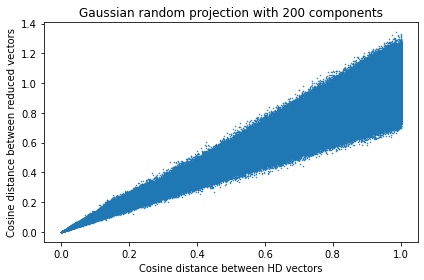

In [12]:
distances = getDistances(df_sps_lab['sp'].tolist()[:5000], vec_hd[0:5000,:], 200)
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(distances[0], distances[3], s=0.1)
ax.set(xlabel='Cosine distance between HD vectors',
              ylabel='Cosine distance between reduced vectors',
              title='Gaussian random projection with 200 components')
plt.tight_layout()
plt.savefig('dimensionReduction/gauss_200components.png', dpi=300)